In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv
from sklearn.base import clone
from sklearn import datasets
from sklearn.metrics import accuracy_score,r2_score,confusion_matrix,classification_report,recall_score,confusion_matrix,mean_squared_error,precision_score,recall_score,fbeta_score,f1_score,roc_curve,roc_auc_score
from sklearn.linear_model import LogisticRegression,LinearRegression,SGDClassifier,SGDRegressor,Lasso,Ridge,ElasticNet
from sklearn.model_selection import train_test_split,KFold,cross_val_score,ShuffleSplit,cross_val_predict,GridSearchCV,RandomizedSearchCV,HalvingRandomSearchCV,HalvingGridSearchCV
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn import preprocessing
import re
import matplotlib as mpl
from pandas_profiling import ProfileReport
pd.set_option("display.precision", 6)
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification, fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVC
from matplotlib import cm

## Pipline
1- Data understanding<br>
2- Data Exploration <br>
3- Data cleaning <br>
4- Modeling <br>
5- Evaluation

In [2]:
df = pd.read_csv('train.csv')
df.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [3]:
df.shape

(8693, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
((df.isna().sum() / df.shape[0]) * 100)

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

In [6]:
print(f"no. of name unique values: {len(df['Name'].unique())}\nno. of id unique values: {len(df['PassengerId'].unique())}")

no. of name unique values: 8474
no. of id unique values: 8693


ID, and name will never affect the label, so we can drop them

In [7]:
len(df['Cabin'].unique())

6561

the cabin has a nearly unique id as the cabins cant have same id, this will lead to confusion between passengers, so we can drop it too

In [8]:
df2 = df.drop(['PassengerId','Name','Cabin'],axis=1)
df2.shape

(8693, 11)

In [9]:
df2["VIP"] = df2['VIP'].replace({"False":0,"True":1}).astype(np.float16)
df2["CryoSleep"] = df2['CryoSleep'].replace({"False":0,"True":1}).astype(np.float16)

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   float16
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   float16
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   bool   
dtypes: bool(1), float16(2), float64(6), object(2)
memory usage: 585.9+ KB


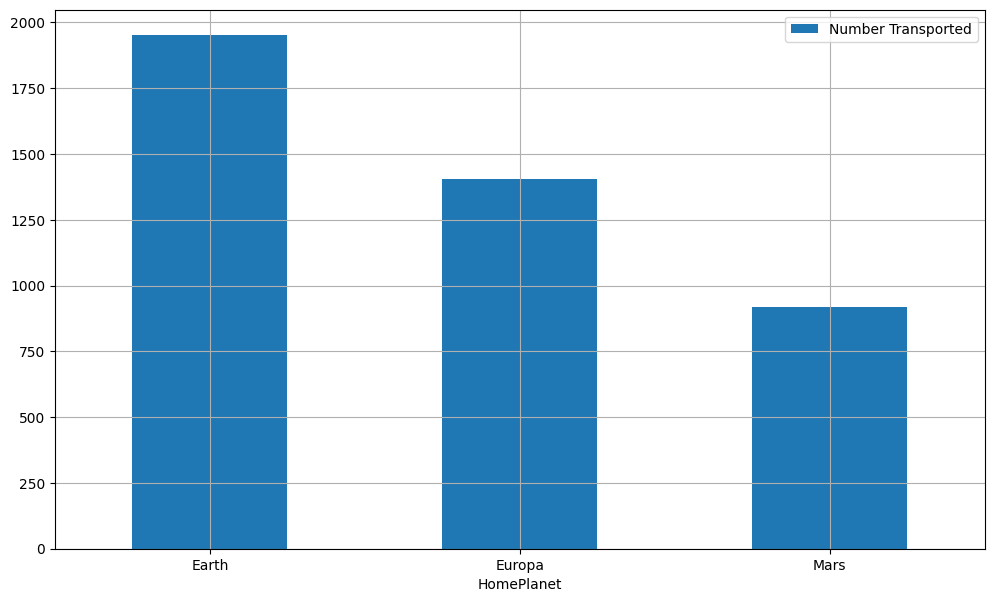

In [11]:
count_transported=df2.groupby('HomePlanet')['Transported'].apply(lambda x: (x==1).sum()).reset_index(name='Number Transported')
color = cm.inferno_r(np.linspace(.4, .8, 30))
count_transported= count_transported.sort_values("Number Transported" , ascending=False)
count_transported.plot.bar(x='HomePlanet', y='Number Transported', figsize=(12,7))
plt.xticks(rotation = 0)
plt.grid()
plt.show()

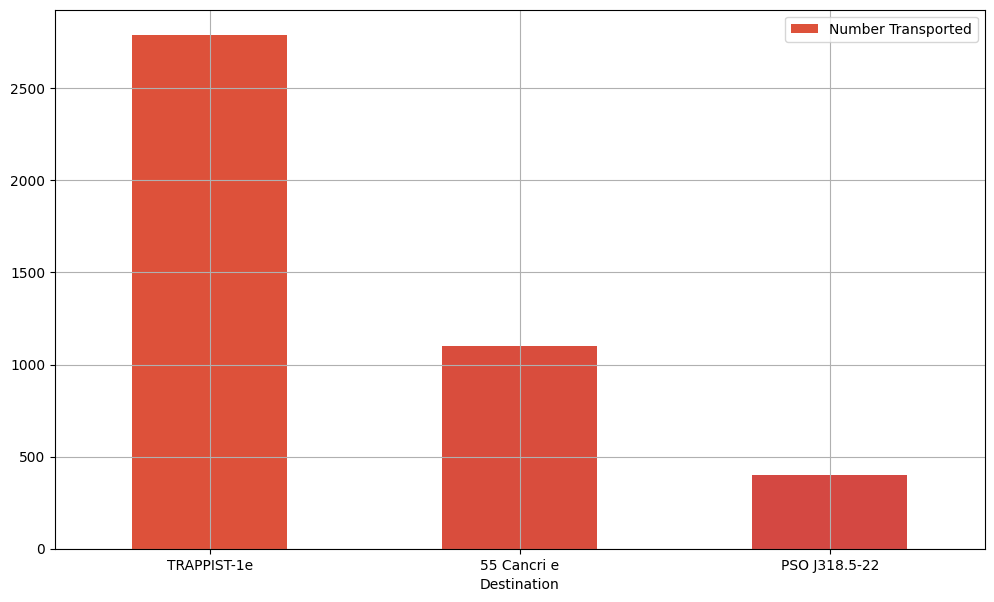

In [12]:
count_transported=df2.groupby('Destination')['Transported'].apply(lambda x: (x==1).sum()).reset_index(name='Number Transported')
color = cm.inferno_r(np.linspace(.4, .8, 30))
count_transported= count_transported.sort_values("Number Transported" , ascending=False)
count_transported.plot.bar(x='Destination', y='Number Transported',color=color, figsize=(12,7))
plt.xticks(rotation = 0)
plt.grid()
plt.show()

Therefore, there is correlation between label (Transported), and categorical columns (HomePlanet,Destination), so we have to encode them

In [13]:
# function to encode features using label encoder
def encode_categories(features):
    le= preprocessing.LabelEncoder()
    for i in range(len(features)):
        df2[features[i]] = le.fit_transform(df2[features[i]])

In [14]:
encode_categories(['HomePlanet','Destination'])

In [15]:
df2.isna().sum()

HomePlanet        0
CryoSleep       217
Destination       0
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

In [16]:
df2.shape

(8693, 11)

In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   int64  
 1   CryoSleep     8476 non-null   float16
 2   Destination   8693 non-null   int64  
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   float16
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   bool   
dtypes: bool(1), float16(2), float64(6), int64(2)
memory usage: 585.9 KB


In [18]:
df3 = df2.dropna()
null_values = df2.shape[0]-df3.shape[0]
print(f"the percentage of null values is: {(null_values/df2.shape[0])*100}")

the percentage of null values is: 16.58805935810422


the number of null values is big so, we cant drop null values, we will try to handle them

In [19]:
x = df2[df2["Age"]==0]
len(x)

178

There is 178 passenger has 0 years old ^_^, is it possible? so, we will drop this rows

In [20]:
df2.drop(df[df["Age"]==0].index,axis=0,inplace=True)

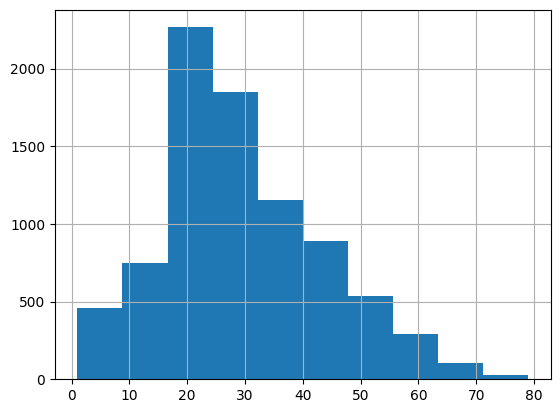

mean of age: 29.443498080614205
median of age: 27.0


In [21]:
df2["Age"].hist()
plt.show()
age_mean = df2["Age"].mean()
age_median = df2["Age"].median()
print(f"mean of age: {age_mean}\nmedian of age: {age_median}")

There is no outliers so, we can handle the null values by mean

In [22]:
df2["Age"].fillna(age_mean,inplace=True)
df2.Age.isna().sum()

0

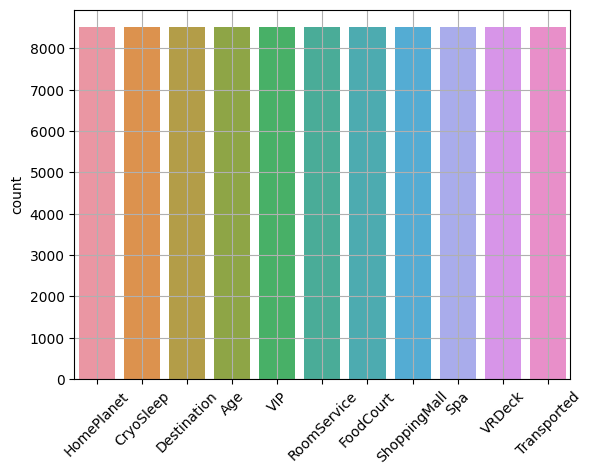

In [25]:
sns.countplot(data=df2)
plt.xticks(rotation=45)
plt.grid()
plt.show()

As we see most passengers dont go with the vip, so we can fill null values with zeros

In [26]:
df2["VIP"].fillna(0,inplace=True)
df2.VIP.isna().sum()

0

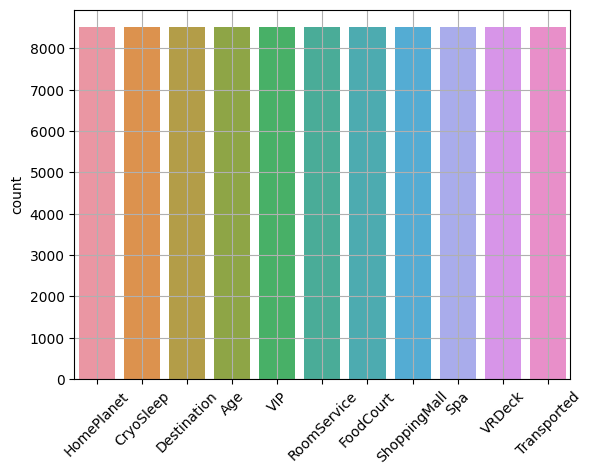

0.0    5335
1.0    2966
Name: CryoSleep, dtype: int64

In [29]:
# sns.countplot('CryoSleep',data=df2)
sns.countplot(data=df2)
plt.xticks(rotation=45)
plt.grid()
plt.show()
df2["CryoSleep"].value_counts()

In [30]:
print(df2[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].min())
print(df2[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].max())
print(df2[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].mean())

RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64
RoomService     14327.0
FoodCourt       29813.0
ShoppingMall    23492.0
Spa             22408.0
VRDeck          24133.0
dtype: float64
RoomService     229.376469
FoodCourt       467.751020
ShoppingMall    177.323710
Spa             317.671386
VRDeck          311.184590
dtype: float64


In [31]:
for i in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']:
    print(df2[i].value_counts())


0.0       5403
1.0        117
2.0         79
3.0         61
4.0         47
          ... 
1230.0       1
987.0        1
930.0        1
3097.0       1
1186.0       1
Name: RoomService, Length: 1273, dtype: int64
0.0       5280
1.0        116
2.0         75
4.0         53
3.0         53
          ... 
3206.0       1
3879.0       1
734.0        1
4076.0       1
2325.0       1
Name: FoodCourt, Length: 1507, dtype: int64
0.0       5415
1.0        153
2.0         80
3.0         59
4.0         45
          ... 
2454.0       1
1770.0       1
871.0        1
9058.0       1
1031.0       1
Name: ShoppingMall, Length: 1115, dtype: int64
0.0       5149
1.0        146
2.0        105
5.0         53
3.0         53
          ... 
1104.0       1
892.0        1
1559.0       1
777.0        1
2234.0       1
Name: Spa, Length: 1327, dtype: int64
0.0        5322
1.0         139
2.0          70
3.0          56
5.0          51
           ... 
8040.0        1
1920.0        1
5913.0        1
11213.0       1
1543.

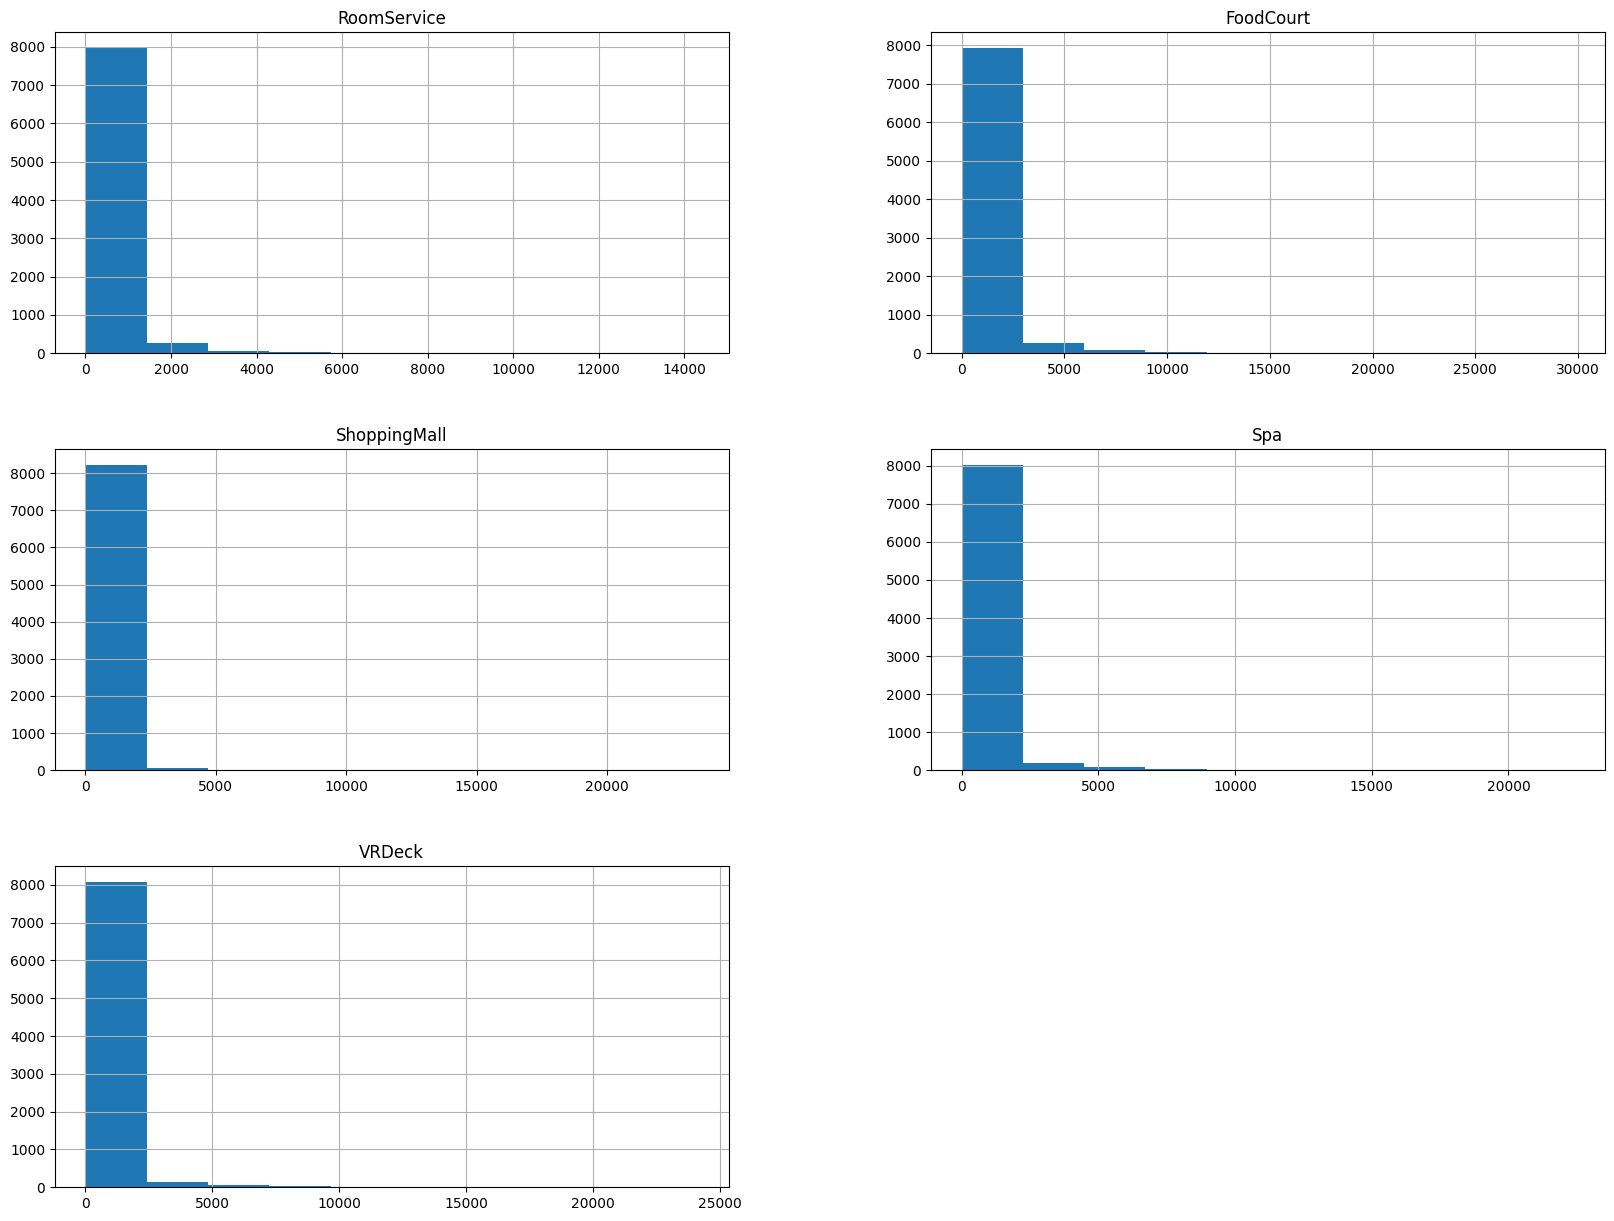

In [32]:
df2[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].hist(figsize=(20,15))
plt.grid()
plt.show()

As we see in the previous cells the most frequent nimber is zero so, we can fill null values wih zero

In [33]:
df2.fillna(0,inplace=True)

In [34]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8515 entries, 0 to 8692
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8515 non-null   int64  
 1   CryoSleep     8515 non-null   float16
 2   Destination   8515 non-null   int64  
 3   Age           8515 non-null   float64
 4   VIP           8515 non-null   float16
 5   RoomService   8515 non-null   float64
 6   FoodCourt     8515 non-null   float64
 7   ShoppingMall  8515 non-null   float64
 8   Spa           8515 non-null   float64
 9   VRDeck        8515 non-null   float64
 10  Transported   8515 non-null   bool   
dtypes: bool(1), float16(2), float64(6), int64(2)
memory usage: 640.3 KB


In [35]:
df2.isna().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

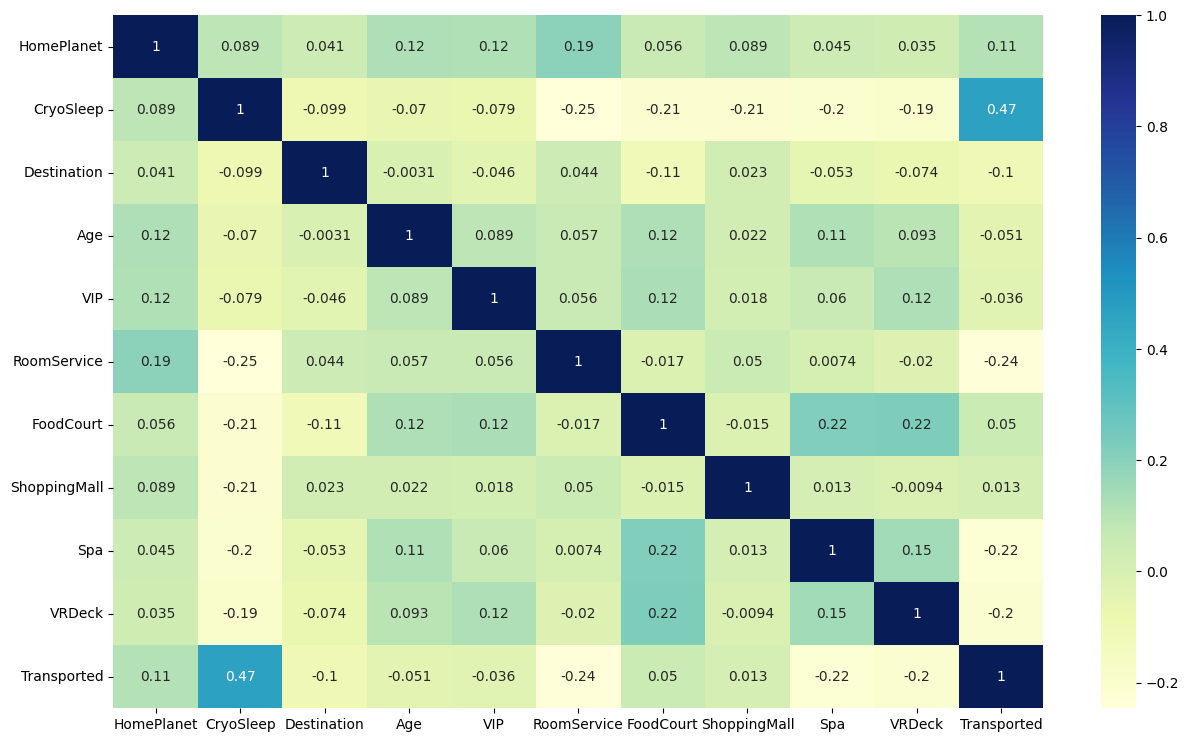

In [36]:
fig,ax = plt.subplots(figsize=(15,9))
sns.heatmap(df2.corr(),annot=True,cmap="YlGnBu")
plt.show()


In [37]:
X_train = df2.drop('Transported',axis=1)
y_train = df2["Transported"]

In [38]:
X_test = pd.read_csv('test.csv')
passenger = X_test['PassengerId']
X_test = X_test.drop(['PassengerId','Name','Cabin'],axis=1)
X_test["VIP"] = X_test['VIP'].replace({"False":0,"True":1}).astype(np.float16)
X_test["CryoSleep"] = X_test['CryoSleep'].replace({"False":0,"True":1}).astype(np.float16)
def encode_categories(features):
    le= preprocessing.LabelEncoder()
    for i in range(len(features)):
        X_test[features[i]] = le.fit_transform(X_test[features[i]])
encode_categories(['HomePlanet','Destination'])
age_mean = X_test["Age"].mean()
age_median = X_test["Age"].median()
X_test["Age"].fillna(age_mean,inplace=True)
X_test.fillna(0,inplace=True)

In [39]:
X_test.isna().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

In [ ]:
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 5)))

In [ ]:
for name, model in models:
    print(name)
    trained_model = model.fit(X_train, y_train)
    predictions = trained_model.predict(X_test) 
    print(f"train score: {accuracy_score(y_train, trained_model.predict(X_train))}\n")

So, as random forest has best training set, we will make tuning on random forest

In [ ]:
predictions

## Tuning

In [ ]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4,5,6] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points
random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}
rf = RandomForestClassifier()

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [ ]:
rf_random.fit(X_train,y_train)
print(f"train score: {accuracy_score(y_train, rf_random.predict(X_train))}\n")

In [ ]:
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

In [ ]:
randmf = RandomForestClassifier(n_estimators = 100, min_samples_split = 6, min_samples_leaf= 4, max_features = 'sqrt', max_depth= 120, bootstrap=False) 
randmf.fit( X_train, y_train)
print(f"train score: {accuracy_score(y_train, randmf.predict(X_train))}\n")

## the accuracy decreased with the tuning, but the tuning handle the overfitting too, so i think that there was an overfitting in testing set before tuning

In [ ]:
y_prediction = randmf.predict(X_test)
y_prediction

In [ ]:
data = {'PassengerId': passenger,
        'Transported': y_prediction}
  
# Create DataFrame
final = pd.DataFrame(data)
final.head()


In [ ]:
final.to_csv('Spaceship Titanic.csv',index=False)